In [26]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy import recarray

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torchvision import transforms
import torch.utils.data as data
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

import os
import copy
import platform
import secrets

if torch.cuda.is_available():
    device = 'cuda'
    print('on cuda')
elif torch.backends.mps.is_available():
    device = 'mps'
    print('on mps')
else:
    device = 'cpu'
    print('on cpu')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

on cuda


In [27]:
class mHealth(data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        return sequence

#pad sequences that aren't 128 length with 0's
def collate_fn(data):
    inputs = [torch.tensor(d) for d in data]

    inputs = pad_sequence(inputs, batch_first=True)

    return inputs

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):#, dropout_prob=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.2,
        )
        
        self.fc = nn.Linear(num_layers, 1)

    def forward(self, x):
        
        outputs, (hidden, cell) = self.lstm(x.to(device))
        
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):#, dropout_prob=0.2):
        
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        # self.dropout_prob = dropout_prob
        print("decoder layers: ", self.num_layers)
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=0.2,
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size
        )

    def forward(self, x, hidden):
        
        hidden = (hidden[0], hidden[1])
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(self, input_size, hidden_size, latent_size, seq_len, num_layers, device, dropout_prob):
        """
        input_size: int, number of input features, default=3
        hidden_size: int, size of hidden layer, default=256
        latent_size: int, latent z-layer size, default=128
        seq_size: int, sequence length of input
        num_layers: int, number of layers in LSTM, default=2
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # init
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
            # dropout=self.dropout_prob
        )

        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
            # dropout=self.dropout_prob
        )


        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)
        self.fc_fix = nn.Linear(self.seq_len * self.num_layers, self.seq_len)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.shape

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)

        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)
    
    def encode(self, x):
        batch_size, seq_len, feature_dim = x.shape
        
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        
        return z
    
    def decode(self, z):
        batch_size, seq_len, feature_dim = z.shape
        
        h_ = self.fc3(z)
        
        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)
        
        return x_hat
    
    def reconstruct(self, x):
        # print("reconstruct x shape: ", x.shape)
        batch_size, seq_len, feature_dim = x.shape
        

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        latent = z
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)
        
        # print("x hat shape: ", x_hat.shape)

        return latent, x_hat

    def loss_function(self, *args, **kwargs) -> dict:
        """
        
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0].to(device).unsqueeze(dim=2)
        input = args[1].to(device)
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

0        -9.8184
1        -9.8489
2        -9.6602
3        -9.6507
4        -9.7030
           ...  
161275   -9.4032
161276   -9.5201
161277   -9.3682
161278   -8.6702
161279   -8.7211
Name: chest acceleration X-axis, Length: 161280, dtype: float64

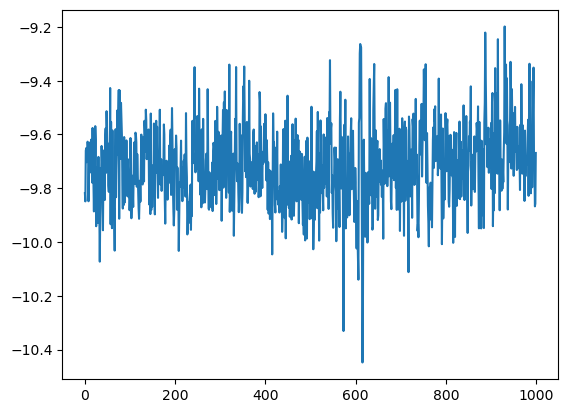

In [29]:
if(platform.system() == 'Darwin'):
    print('hi')

dataset_path = os.getcwd() + '/processed_data/mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)
dataset = dataset['chest acceleration X-axis'] #drop all columns that aren't chest accel info
plt.plot(dataset[:1000])

dataset

In [30]:
LOAD_MODEL = False
split_idx = int(len(dataset) * 0.8)

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
)

batch_size = 256
input_size = 1
hidden_size = 256
latent_size = 128
sequence_len = 128
num_layers = 2
clip_value = 5
dropout_prob = 0.2

# define LSTM-based VAE model
if(LOAD_MODEL):
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)
    if(platform.system() == 'Darwin'):
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
    elif(platform.system() == 'Windows'):
        model.load_state_dict(torch.load('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\aug_3_2_layers'))
    else:
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
        print("linux")
    print("model loaded from state dict | system: ", platform.system())
else:
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device, dropout_prob=dropout_prob)

model.to(device)
print("training on: ", device)
print('----------------------------------------------------------------\n', 
      model)

decoder layers:  2
training on:  cuda
----------------------------------------------------------------
 LSTMVAE(
  (lstm_enc): Encoder(
    (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=2, out_features=1, bias=True)
  )
  (lstm_dec): Decoder(
    (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc21): Linear(in_features=256, out_features=128, bias=True)
  (fc22): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc_fix): Linear(in_features=256, out_features=128, bias=True)
)


In [31]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")


for idx, data in enumerate(train_loader):
    datas = data
    print("datas shape: ", datas.shape)
    break

train_loss = []
test_loss = []
learning_rate = []

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x0000022219FB1D90>
Length of train_dataloader: 504 batches of 256
datas shape:  torch.Size([256, 128, 1])


C:\Users\Admin\AppData\Local\Temp\ipykernel_25996\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [61]:
clip_value = 10

def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

    ## interation setup
    epochs = tqdm(range(iterations // len(train_loader)))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader)-32, desc="training"
        )
        
        temp = -1
        
        for i, batch_data in train_iterator:

            if count > iterations:
                return model
            count += 1

            past_data = batch_data

            mloss, recon_x, recon_loss = model(past_data)

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
            temp = float(mloss.mean())
            
        if(temp != -1):
            train_loss.append(temp)
            
        before_lr = optimizer.param_groups[0]["lr"]
        learning_rate.append(float(before_lr))
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for i, batch_data in test_iterator:
                past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )

                mloss, recon_x, info = model(past_data)

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"test_loss": float(mloss.mean())})
                temp = float(mloss.mean())
            
        if(temp != -1):
            test_loss.append(temp)
        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
        torch.cuda.empty_cache()

    return model


In [62]:
iterations = 500000 ## iterations = total iterations, epochs = iterations / len(dataloader)
train(iterations, model, train_loader, test_loader)


  0%|          | 0/992 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_25996\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
training: 504it [00:49, 10.27it/s, train_loss=22]


Epoch 0: SGD lr 0.0010 -> 0.0010


  0%|          | 1/992 [00:54<14:54:39, 54.17s/it]

Evaluation Score : [5.7962998692241925]


training: 504it [00:47, 10.61it/s, train_loss=21.6]


Epoch 1: SGD lr 0.0010 -> 0.0010


  0%|          | 2/992 [01:46<14:38:44, 53.26s/it]

Evaluation Score : [5.851524792966389]


training: 504it [00:47, 10.58it/s, train_loss=21.6]


Epoch 2: SGD lr 0.0010 -> 0.0010


  0%|          | 3/992 [02:39<14:33:33, 53.00s/it]

Evaluation Score : [5.868633173169598]


training: 504it [00:47, 10.51it/s, train_loss=21.8]


Epoch 3: SGD lr 0.0010 -> 0.0010


  0%|          | 4/992 [03:32<14:32:46, 53.00s/it]

Evaluation Score : [5.787494010277211]


training: 504it [00:48, 10.40it/s, train_loss=24.9]


Epoch 4: SGD lr 0.0010 -> 0.0010


  1%|          | 5/992 [04:26<14:36:05, 53.26s/it]

Evaluation Score : [5.763048643394122]


training: 504it [00:48, 10.41it/s, train_loss=23.5]


Epoch 5: SGD lr 0.0010 -> 0.0010


  1%|          | 6/992 [05:19<14:37:15, 53.38s/it]

Evaluation Score : [5.739021171120897]


training: 504it [00:48, 10.40it/s, train_loss=22.1]


Epoch 6: SGD lr 0.0010 -> 0.0010


  1%|          | 7/992 [06:13<14:38:22, 53.51s/it]

Evaluation Score : [5.736068569478535]


training: 504it [00:47, 10.55it/s, train_loss=21.3]


Epoch 7: SGD lr 0.0010 -> 0.0010


  1%|          | 7/992 [07:03<16:34:12, 60.56s/it]


KeyboardInterrupt: 

In [63]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for batch in dataloader:

            x = batch  # Assuming batch is a tuple (data, target), adjust if necessary

            batch_size = x.size(0)
            example_size = x.size(1)
            x = (
                x.view(batch_size, example_size, -1).float().to(device)
            )

            mloss, recon_x, info = model(x)

            recon_x = recon_x[:, 0]
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

In [64]:
reconstruction = predict(model, train_loader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25996\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [65]:
print(len(reconstruction))
print(reconstruction[1000])

129024
tensor(-9.1081, device='cuda:0')


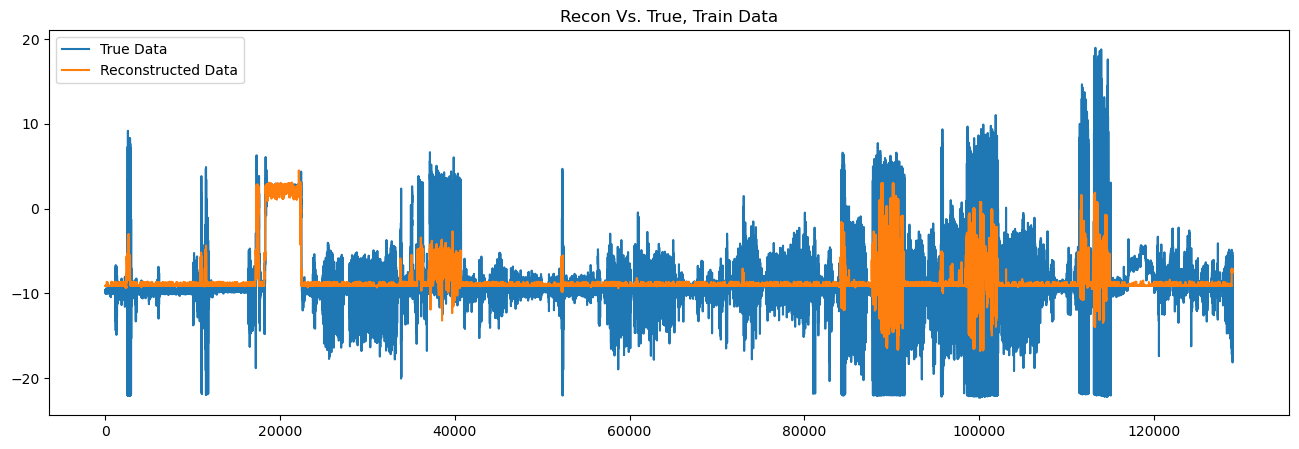

In [66]:
plt.figure(figsize=(16,5))
plt.title("Recon Vs. True, Train Data")
plt.plot(dataset[:split_idx], label="True Data")
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

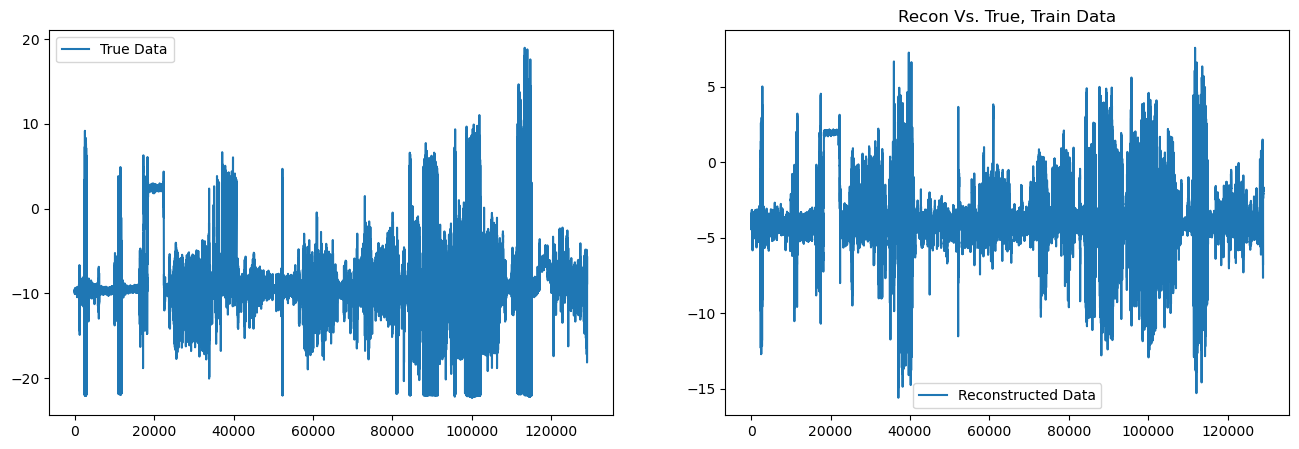

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(dataset[:split_idx], label="True Data")
plt.legend()
plt.subplot(1,2,2)
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


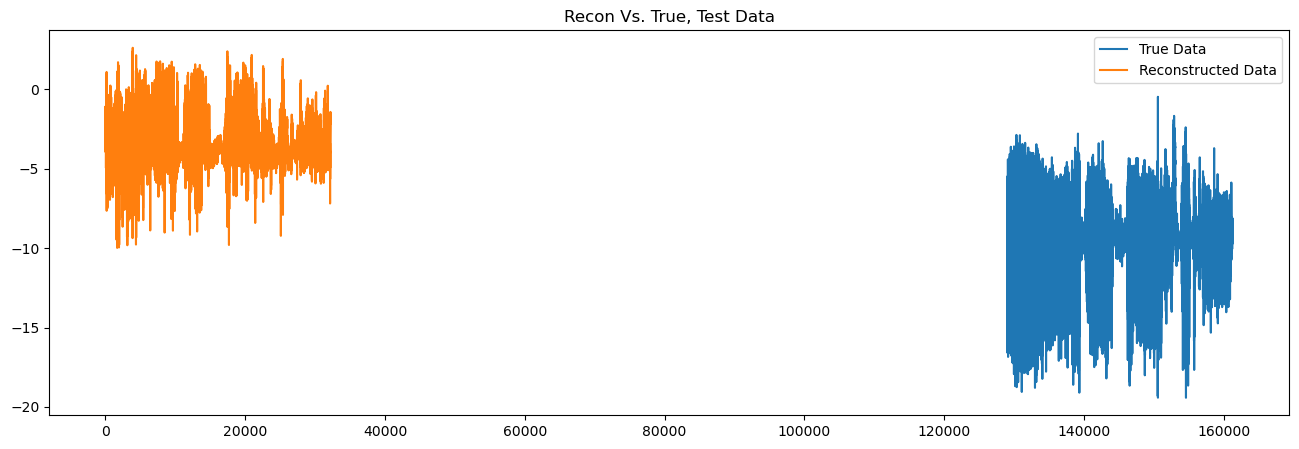

In [ ]:
test_recon = predict(model, test_loader)

plt.figure(figsize=(16,5))
plt.plot(dataset[split_idx:], label="True Data")
plt.plot(test_recon.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Test Data")
plt.legend()

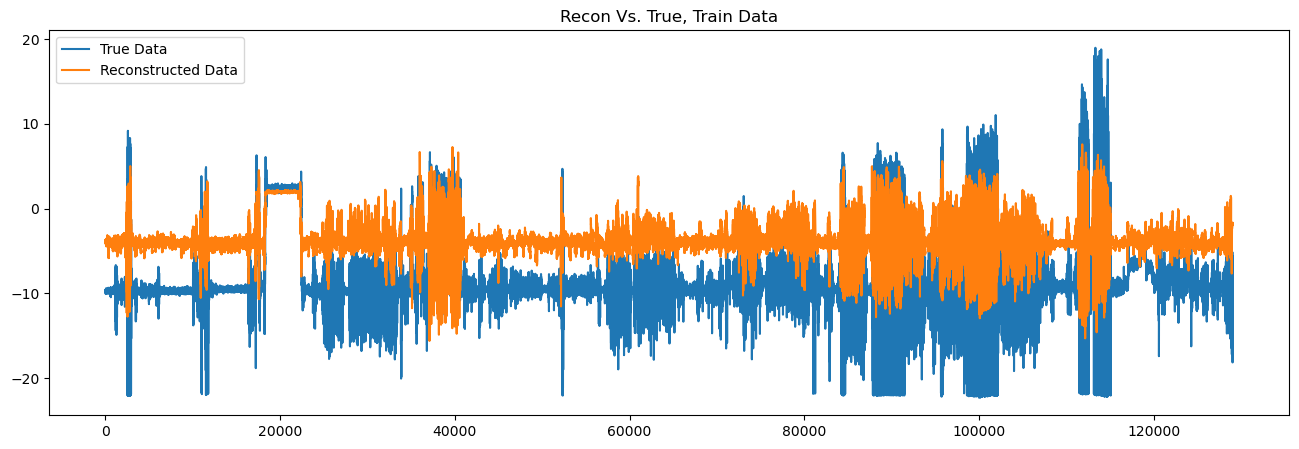

In [ ]:
# plt.subplots(2)
plt.figure(figsize=(16,5))
plt.plot(dataset[:split_idx], label="True Data")
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

In [ ]:
subject_2 = pd.read_csv('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject2.csv')
sub_2_split_idx = int(len(subject_2) * 0.8)
subject_2 = subject_2['chest acceleration X-axis']

subject_2

0        -9.8646
1        -9.7753
2        -9.6195
3        -9.7610
4        -9.8078
           ...  
130556   -9.4231
130557   -9.5361
130558   -9.4680
130559   -9.6448
130560   -9.0025
Name: chest acceleration X-axis, Length: 130561, dtype: float64

In [ ]:
# training dataset
sub_2_train = mHealth(
    dataframe=subject_2[:split_idx],
)

sub_2_test = mHealth(
    dataframe=subject_2[split_idx:],
)

sub_2_whole = mHealth(
    dataframe=subject_2,
)

sub_2_train_loader = torch.utils.data.DataLoader(
    dataset=sub_2_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

sub_2_test_loader = torch.utils.data.DataLoader(
    dataset=sub_2_test,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

sub_2_whole_loader = torch.utils.data.DataLoader(
    dataset=sub_2_whole,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

In [ ]:
# sub_2_recon = predict(model, sub_2_whole_loader)

In [ ]:
# # plt.subplots(2)
# plt.figure(figsize=(16,5))
# plt.plot(subject_2, label="True Data")
# plt.plot(sub_2_recon.cpu(), label="Reconstructed Data")
# plt.title("Recon Vs. True, Train Data")
# plt.legend()

In [ ]:
# subject_3 = pd.read_csv('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject3.csv')
# sub_3_split_idx = int(len(subject_3) * 0.8)
# subject_3 = subject_3['chest acceleration X-axis']

# # training dataset
# sub_3_train = mHealth(
#     dataframe=subject_3[:split_idx],
# )

# sub_3_test = mHealth(
#     dataframe=subject_3[split_idx:],
# )

# sub_3_whole = mHealth(
#     dataframe=subject_3,
# )

# sub_3_train_loader = torch.utils.data.DataLoader(
#     dataset=sub_3_train,
#     batch_size=batch_size,
#     collate_fn=collate_fn,
#     shuffle=False,
#     drop_last=True
# )

# sub_3_test_loader = torch.utils.data.DataLoader(
#     dataset=sub_3_test,
#     batch_size=batch_size,
#     collate_fn=collate_fn,
#     shuffle=False,
#     drop_last=True
# )

# sub_3_whole_loader = torch.utils.data.DataLoader(
#     dataset=sub_3_whole,
#     batch_size=batch_size,
#     collate_fn=collate_fn,
#     shuffle=False,
#     drop_last=True
# )

# sub_3_recon = predict(model, sub_3_whole_loader)

# # plt.subplots(2)
# plt.figure(figsize=(16,5))
# plt.plot(subject_3, label="True Data")
# plt.plot(sub_3_recon.cpu(), label="Reconstructed Data")
# plt.title("Recon Vs. True")
# plt.legend()

In [ ]:
def plot_predictions(model):
    for i in range(10):

        path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject' + str(i+1) + '.csv'
        df = pd.read_csv(path)
        
        df = df['chest acceleration X-axis']
        
        df = df.to_numpy().reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(-10, 10))

        df = scaler.fit_transform(df)
        df = pd.Series(df.squeeze())
        
        dataset = mHealth(
            dataframe=df,
        )
        
        dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=512,
            collate_fn=collate_fn,
            shuffle=False,
            drop_last=True
        )
        
        reconstructed_data = predict(model, dataloader)
        
        plt.figure(figsize=(16,5))
        plt.plot(df, label="True Data")
        plt.plot(reconstructed_data.cpu(), label="Reconstructed Data")
        plt.title("Recon Vs. True, Whole Dataset")
        plt.legend()
                

C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\1931177812.py:29: UserWarning

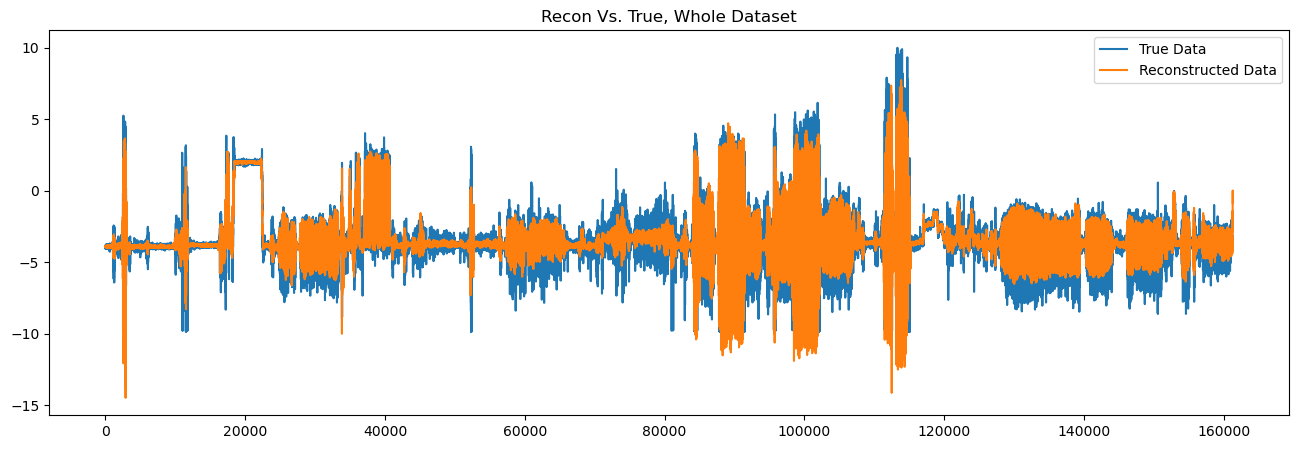

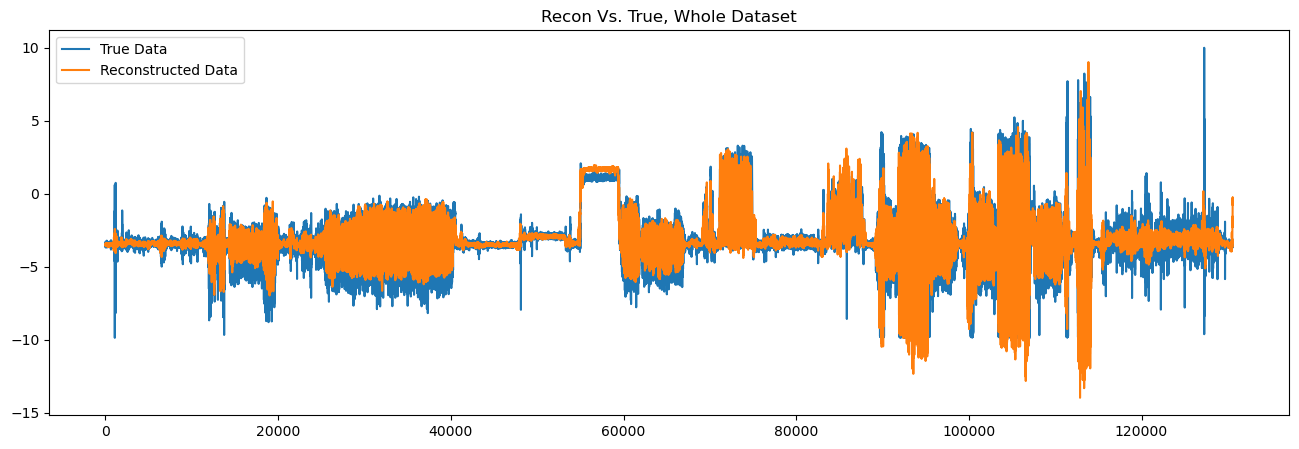

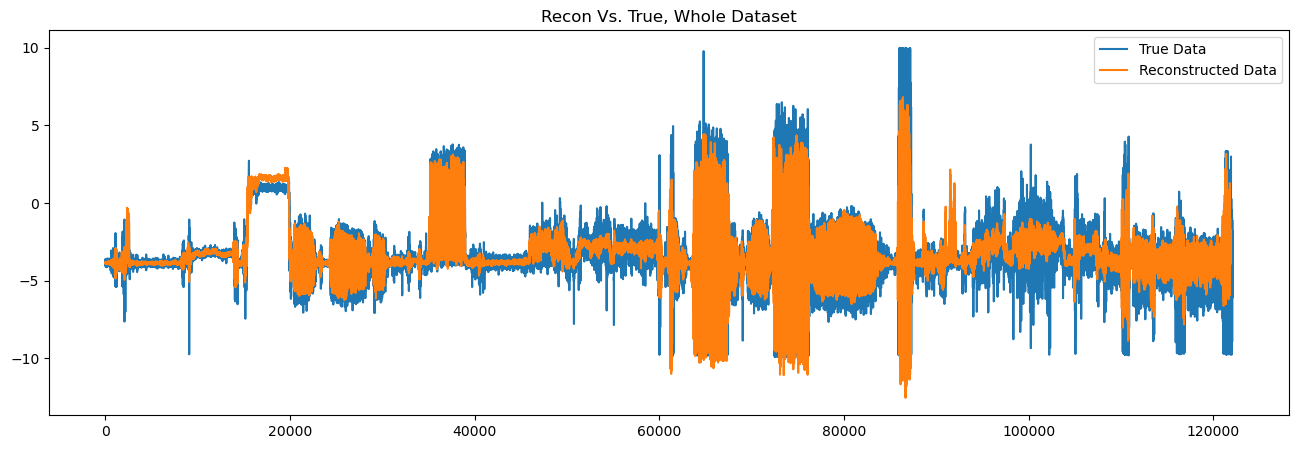

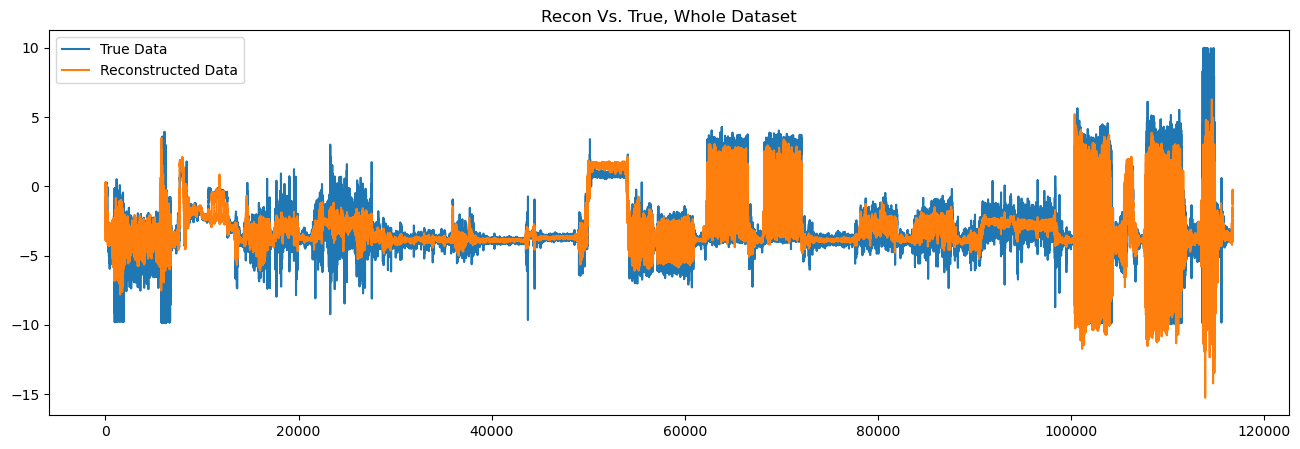

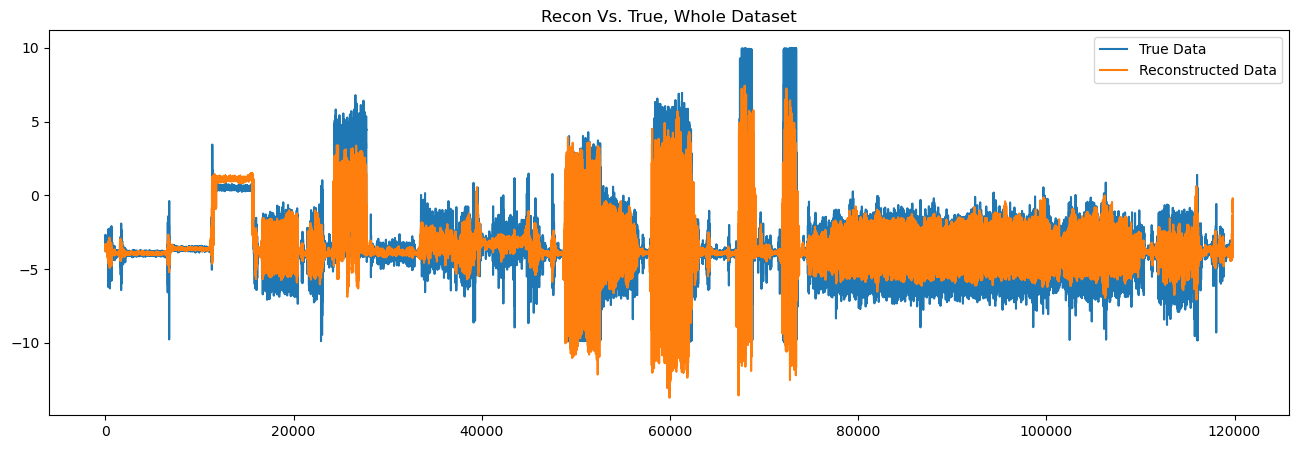

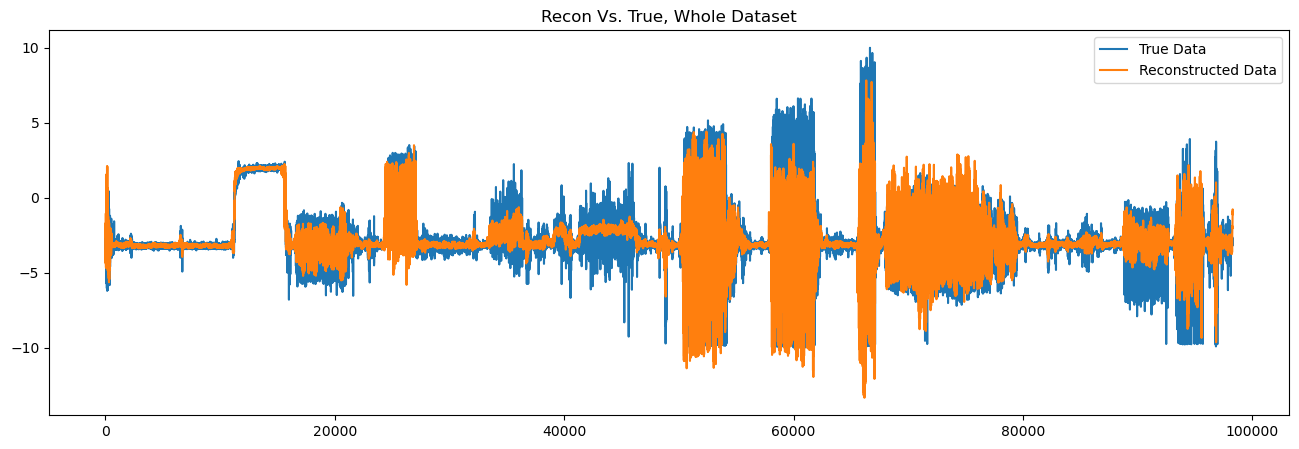

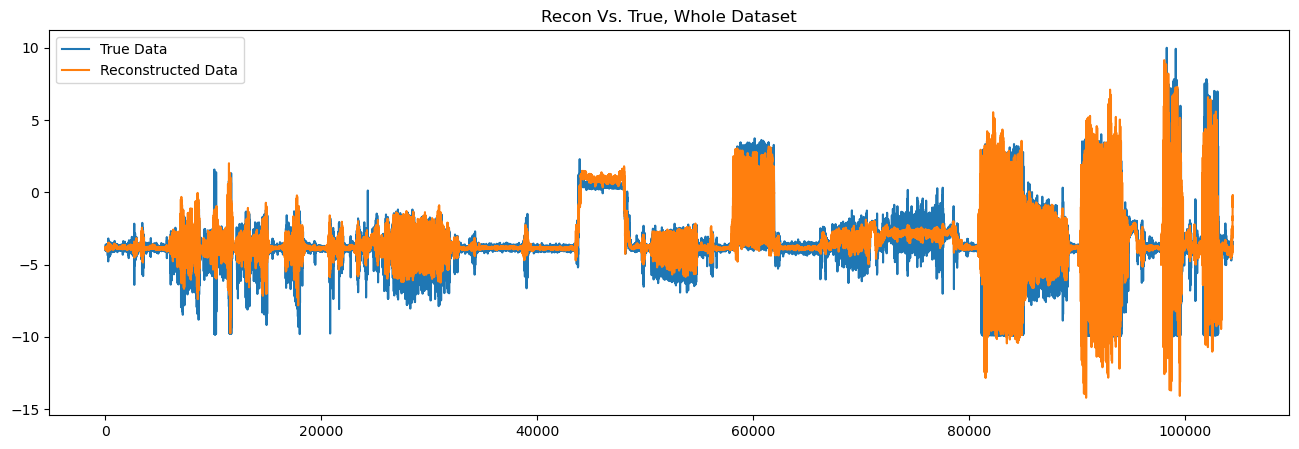

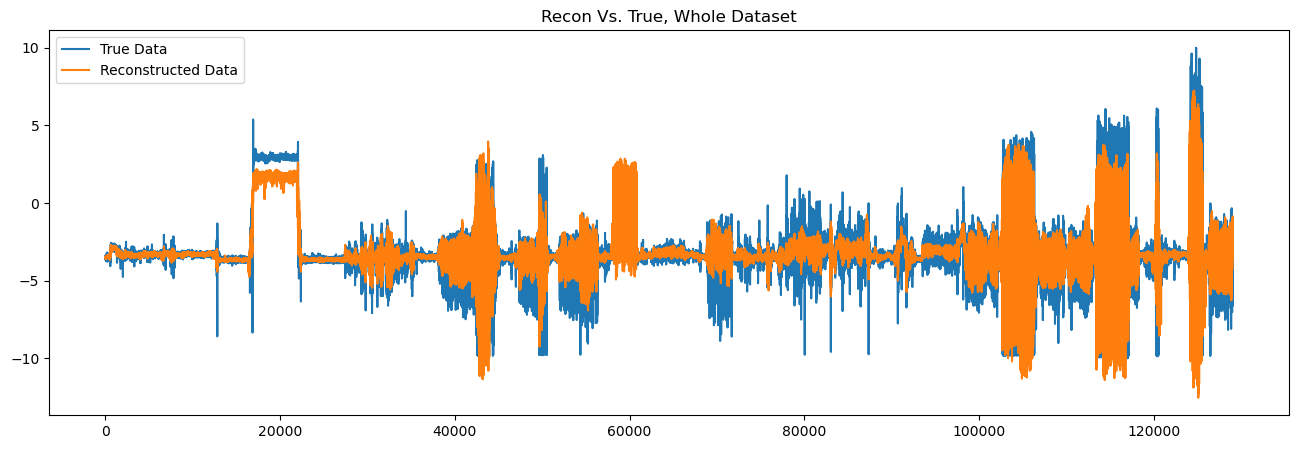

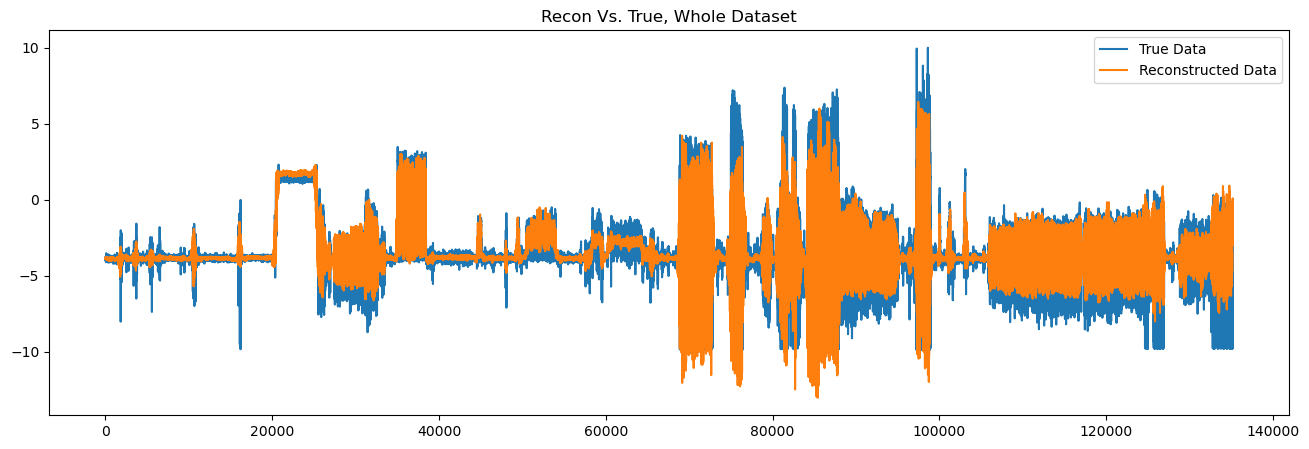

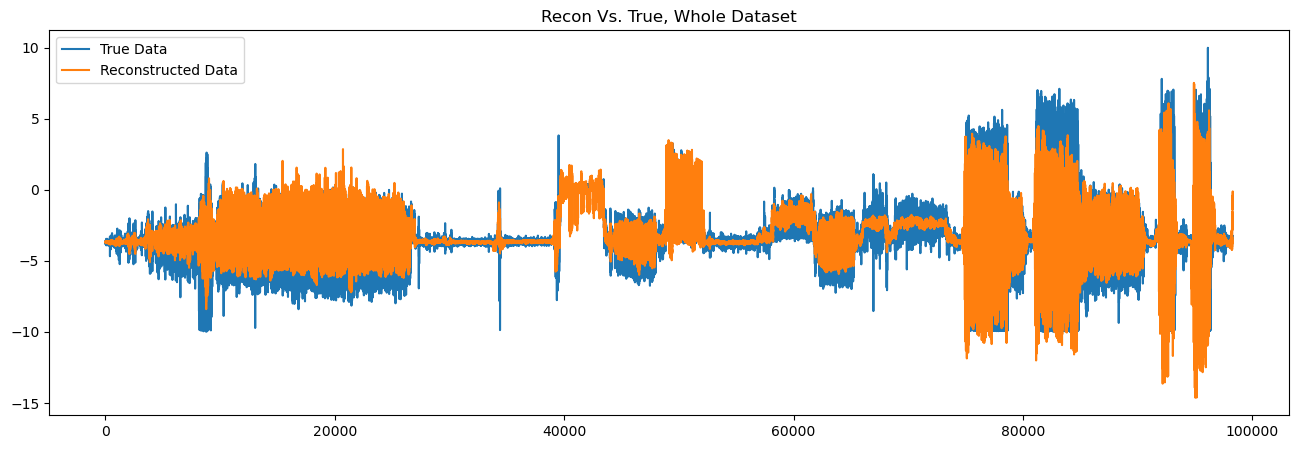

In [ ]:
plot_predictions(model)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def plot_predictions_daphnet(model):
    # for i in range(10):

    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV\\S01R01.csv'
    path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV\\S08R01.csv'
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\smartphone activity detection\\train.csv'
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MobiAct_Dataset_v2.0\\Annotated Data\\BSC\\BSC_1_1_annotated.csv'
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\UPFallCompleteDataSet.csv'
    
    df = pd.read_csv(path)
    # df = df['tBodyAcc-mean()-X']
    # df = df['acc_x']
    # df = df['BeltAccelerometer']
    df = df['trunk acceleration lateral']
    # df = df['trunk acceleration forward']
    
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\Daphnet_CSV\\S01R01.csv'
    # df = pd.read_csv(path)
    
    # df = df['trunk acceleration lateral']
    
    df = df.to_numpy().reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-10, 10))

    df = scaler.fit_transform(df)
    df = pd.Series(df.squeeze())
    
    dataset = mHealth(
        dataframe=df,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=512,
        collate_fn=collate_fn,
        shuffle=False,
        drop_last=True
    )
    
    reconstructed_data = predict(model, dataloader)
    
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))  # 3 rows, 1 column
    axs[0].plot(df, label="True Data")
    axs[0].plot(reconstructed_data.cpu(), label="Reconstructed Data")
    axs[0].set_title("Recon Vs. True, Daphnet")
    axs[0].legend()
    
    axs[1].plot(df, label="True Data")
    axs[1].set_title("True Daphnet")
    axs[1].legend()
    
    axs[2].plot(reconstructed_data.cpu(), label="Reconstructed Data", color='orange')
    axs[2].set_title("Recon Daphnet")
    axs[2].legend()
    
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


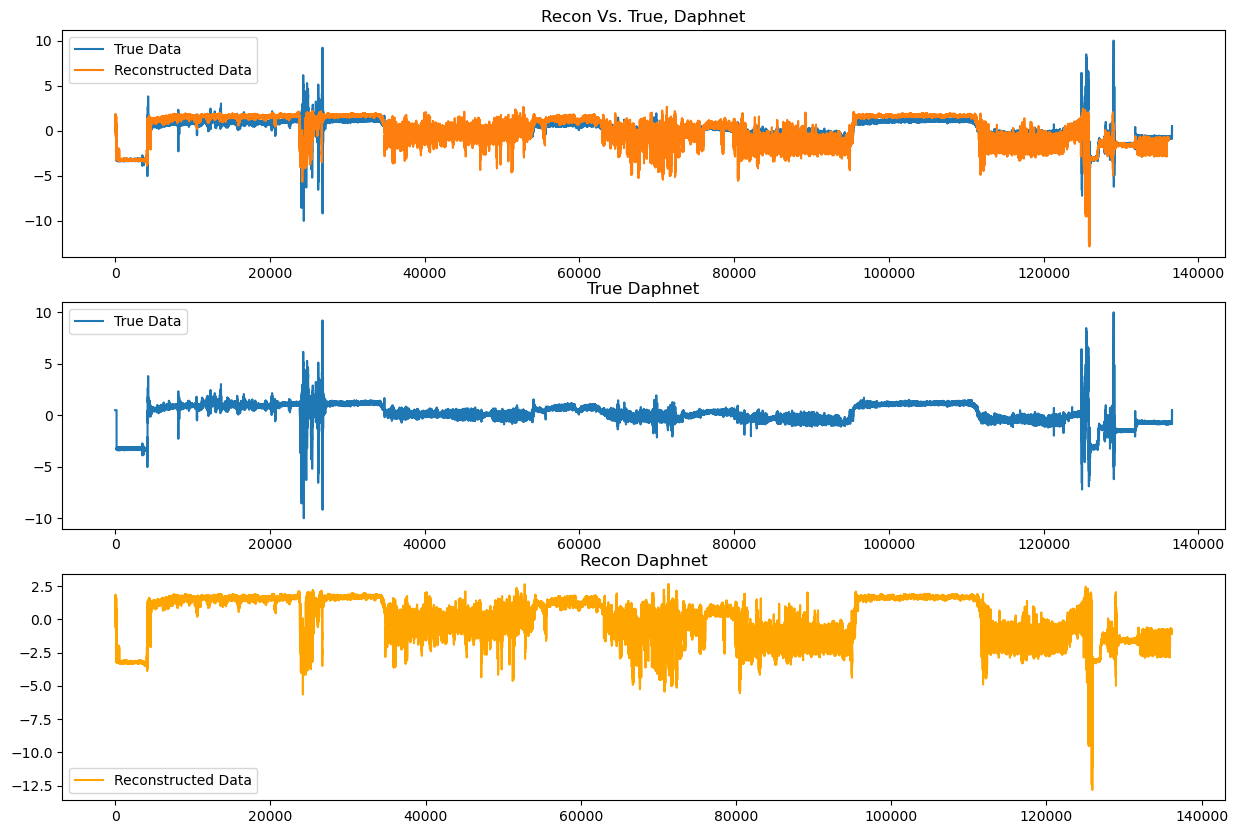

In [ ]:
plot_predictions_daphnet(model)

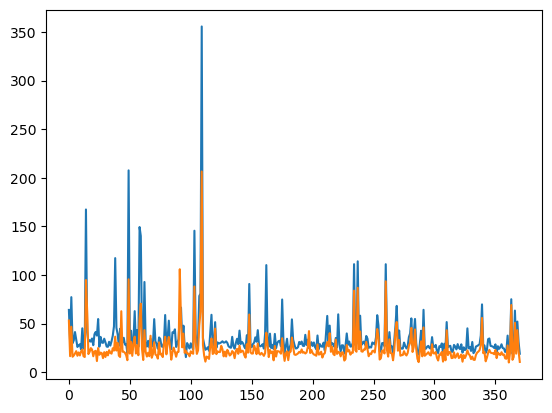

In [49]:
plt.plot(train_loss)
plt.plot(test_loss)

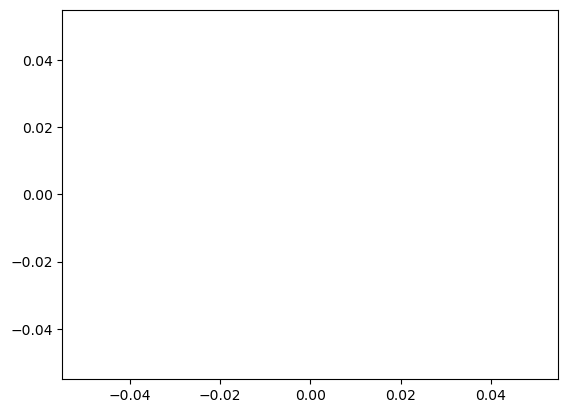

In [ ]:
plt.plot(learning_rate)

In [ ]:
# cwd = os.getcwd() + "/MHEALTHDATASET_CSV"
if(platform.system() == 'Windows'):
    cwd = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV'
else:
    cwd = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV'

print(cwd)

os.chdir(cwd)

#split data into sections by label

df = pd.DataFrame()
dataframes = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{cwd}/{file}"
        temp = pd.read_csv(file_path)
        dataframes.append(temp)
        print('file:', file, '| size = ', len(temp))
        
df = pd.concat(dataframes)

C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTHDATASET_CSV
file: mHealth_subject1.csv | size =  161280
file: mHealth_subject10.csv | size =  98304
file: mHealth_subject2.csv | size =  130561
file: mHealth_subject3.csv | size =  122112
file: mHealth_subject4.csv | size =  116736
file: mHealth_subject5.csv | size =  119808
file: mHealth_subject6.csv | size =  98304
file: mHealth_subject7.csv | size =  104448
file: mHealth_subject8.csv | size =  129024
file: mHealth_subject9.csv | size =  135168


In [ ]:
#extracts x,y,z chest accel data into different label groups
def partition_data(label, dataframe):
    x_data = []
    y_data = []
    z_data = []
    activity = []
    
    for i in range(len(dataframe)):
        if(df['label'].iloc[i] == label):
            x_data.append(df['chest acceleration X-axis'].iloc[i])
            y_data.append(df['chest acceleration Y-axis'].iloc[i])
            z_data.append(df['chest acceleration Z-axis'].iloc[i])
            activity.append(df['label'].iloc[i])
            
    
    partitioned_df = pd.DataFrame(
                                  {
        'x-axis': x_data,
        'y-axis': y_data,
        'z-axis': z_data,
        'label': activity
                                  })
    
    return partitioned_df

In [ ]:
#splitting all mhealth data based on label, used for classification
df_null = partition_data(0, df)
df_stand = partition_data(1, df) 
df_sit = partition_data(2, df)
df_lying = partition_data(3, df)
df_walk = partition_data(4, df)
df_stairs = partition_data(5, df)
df_waist_bend = partition_data(6, df)
df_arms = partition_data(7, df) 
df_knee_bend = partition_data(8, df) 
df_cycle = partition_data(9, df) 
df_jog = partition_data(10, df) 
df_run = partition_data(11, df) 
df_jump = partition_data(12, df) 

KeyboardInterrupt: 

In [ ]:
class classifier_dataset(torch.utils.data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe['x-axis']
        # print(self.dataset)
        self.labels = dataframe['label']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        # sequence = torch.tensor(self.dataset[index*128:index*128+128].to_numpy()).type(torch.float32) 
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        # print(sequence)
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        # print("seq shape: ", sequence.shape)
        label = torch.tensor(self.labels.iloc[index])
        # print("lavel shape;", label.shape)
        # print(label)
        return sequence, label

#pad sequences that aren't 128 length with 0's
def collate_fn(data):
    labels = []
    for d in data:
        labels.append(torch.tensor(d[1]))
    
    labels = torch.tensor(labels)
    inputs = [torch.tensor(d[0]) for d in data]
    inputs = pad_sequence(inputs, batch_first=True)
    
    # print("data[0][1], ", data[0][1])

    return inputs, labels

In [ ]:
len(df_jump)//128

80

In [ ]:
split_idx = int(len(df_jump) * 0.8)

class_train = classifier_dataset(
    dataframe=df_jump[:split_idx]
)

class_test = classifier_dataset(
    dataframe=df_jump[split_idx:]
)

class_train_loader = torch.utils.data.DataLoader(
    class_train, 
    batch_size=8, 
    shuffle=True, 
    drop_last=True,
    collate_fn=collate_fn
    )

class_test_loader = torch.utils.data.DataLoader(
    class_test, 
    batch_size=8, 
    shuffle=True, 
    drop_last=True,
    collate_fn=collate_fn
    )

In [ ]:
class Classifier(nn.Module):

  def __init__(self, input_dim=128, num_classes=13, num_units=8, dropout=0.5, hidden=True):
    super(Classifier, self).__init__()
    self.fcin = nn.Linear(input_dim, num_units)
    self.fchidden = nn.Linear(num_units, num_units)
    self.fcout = nn.Linear(num_units, num_classes)
    self.dropout = nn.Dropout(dropout)
    self.act = torch.nn.ReLU()
    self.h = hidden


  def forward(self, x):
    # print('x in shape: ', x.shape)
    x = self.act(self.fcin(x))
    if self.h:
      x = self.act(self.fchidden(x))
    x = self.dropout(x)
    x = self.fcout(x)
    # print("x out shape: ", x.shape)
    return x
    
classifier = Classifier().to(device)
class_train_loss = []
class_test_loss = []

In [ ]:
learning_rate = 0.01
num_epochs = 200
i = 0

criterion = nn.CrossEntropyLoss()  # Since it's a classification task
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(class_train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        encoded, _ = model.reconstruct(inputs)
        # print("encoded shape: ", encoded.shape)
        encoded = encoded[0, :, :]
        
        
        
        # Forward pass
        outputs = classifier(encoded).to(device)
        
        # assert outputs.shape[0] == 13, f"Output shape mismatch: {outputs.shape}"
        # assert targets.shape[0] == 4, f"Target shape mismatch: {targets.shape}"
        
        # print(outputs.shape)
        # print(targets.shape)
        # print(type(targets))
       
        y_pred = torch.round(torch.sigmoid(outputs))
        loss = criterion(outputs, targets.type(torch.LongTensor).to(device))
        
        running_train_loss += loss.item() * inputs.size(0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    running_test_loss = 0.0
    
    epoch_train_loss = running_train_loss / len(class_train_loader)
    class_train_loss.append(float(epoch_train_loss))

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(class_test_loader):
            
            encoded, _ = model.reconstruct(inputs)
            encoded = encoded[0, :, :]
            outputs = classifier(encoded).to(device)
            
            loss = criterion(outputs, targets.type(torch.LongTensor).to(device))
            running_test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted.to(device) == targets.to(device)).sum().item()
    
    epoch_test_loss = running_test_loss / len(class_test_loader)
    class_test_loss.append(epoch_test_loss)
    val_accuracy = correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")

C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\4178157600.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels.append(torch.tensor(d[1]))
C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\4178157600.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data]


Epoch [1/200], Loss: 2.5218
Epoch [2/200], Loss: 1.4316
Epoch [3/200], Loss: 1.2344
Epoch [4/200], Loss: 2.1894
Epoch [5/200], Loss: 1.7886
Epoch [6/200], Loss: 1.7604
Epoch [7/200], Loss: 2.4456
Epoch [8/200], Loss: 1.7758
Epoch [9/200], Loss: 1.6485
Epoch [10/200], Loss: 1.8102
Epoch [11/200], Loss: 2.0644
Epoch [12/200], Loss: 2.0208
Epoch [13/200], Loss: 2.3728
Epoch [14/200], Loss: 1.9522
Epoch [15/200], Loss: 2.0717
Epoch [16/200], Loss: 1.8260
Epoch [17/200], Loss: 2.0280
Epoch [18/200], Loss: 2.3065
Epoch [19/200], Loss: 1.7305
Epoch [20/200], Loss: 1.9394


KeyboardInterrupt: 

In [ ]:
temp = df_jump['x-axis'].iloc[:128].to_numpy()
temp = torch.tensor(temp).type(torch.float32)
temp = temp.unsqueeze(dim=0)
temp = temp.unsqueeze(dim=2)
print(temp.shape)
type(temp)

torch.Size([1, 128, 1])


torch.Tensor

In [ ]:
encoded = model.encode(temp)

In [ ]:
print(encoded.shape)

torch.Size([2, 1, 128])


In [ ]:
encoded, decoded = model.reconstruct(temp)

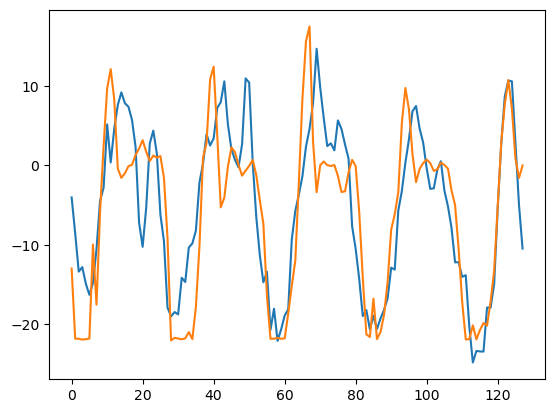

In [ ]:
plt.plot(decoded.detach().cpu().numpy())
plt.plot(df_jump['x-axis'].iloc[:128].to_numpy())

In [ ]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    Classifier,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss()

)

In [ ]:
type(df_jump['x-axis'][0])

numpy.float64

In [ ]:
from sklearn.model_selection import GridSearchCV


# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.001, 0.001],
    'max_epochs': [10, 20, 50],
    'module__num_units': [32, 64],
    'module__dropout': [0.1],
    'module__input_dim': [2],
    'module__num_classes': [13],
    'module__hidden': [True, False]

}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=0)

gs.fit(df_jump['x-axis'].to_numpy(),df_jump['label'].to_numpy())
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

ValueError: 
All the 72 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\optim\optimizer.py", line 391, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\optim\optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\optim\adam.py", line 148, in step
    loss = closure()
           ^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 993, in train_step_single
    y_pred = self.infer(Xi, **fit_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\anaconda3\Lib\site-packages\skorch\net.py", line 1521, in infer
    return self.module_(x, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_33868\1354783692.py", line 14, in forward
    x = self.act(self.fcin(x))
                 ^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\linear.py", line 116, in forward
    return F.linear(input, self.weight, self.bias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float


In [ ]:
def classifier_train()